In [25]:
##############
#K. David Roell CFPB 
#
##############
from collections import OrderedDict
import json
import os
import pandas as pd
import psycopg2
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from math import sqrt
get_ipython().magic(u'matplotlib inline')
matplotlib.style.use('ggplot')
#from macro_sql import Q076 
with open('../quality_sql.json') as f: #FIXME change to quality_sql.json and refactor the rest of code
    edit_sql = json.load(f)
    
#parameter format for local use #consider changing hmdamaster to roellk if db changes cause a fail
params = {
'dbname':'hmdamaster',
'user':'roellk',
'password':'',
'host':'localhost',
}

try:
    conn = psycopg2.connect(**params)
    cur = conn.cursor()
    print("i'm connected")

except psycopg2.Error as e: #if database connection results in an error print the following
    print("I am unable to connect to the database: ", e)

i'm connected


In [26]:
#load single bank data as dataframe
loanType='all' #determines which linked income/amount distribution file is loaded
bank_df = pd.read_csv('../data/income_to_amount_dist__{loanType}.csv'.format(loanType=loanType))
inc_df = bank_df.copy() # split income df out to sort values by income for graphing cumulative income percent
#these data are for single family, conventional, owner occupied, first lien, home purchase loans at the national level
#other analysis will be used for each loan product, lien status, geography, and other variables as appropriate

In [27]:
#sort data frame by amount field, this is useful because multiple years are present
bank_df.sort_values(by='amount', inplace=True)
inc_df.sort_values(by='income', inplace=True)
inc_df.head()

,year,income,amount
0,2014,1,1
803511,2010,1,46
803512,2010,1,47
803513,2010,1,48
803514,2010,1,49


In [28]:
#bank_df = bank_df[bank_df.year == 2014].copy() #select single year
bank_df.income = bank_df.income.map(int) #convert data to numeric
bank_df.amount = bank_df.amount.map(int) #convert data to numeric
bank_df['mult'] = bank_df.amount/bank_df.income #create amount to income multiple

#create percent and cumulative percents by value
bank_df['pct_amt'] = bank_df['amount']/bank_df['amount'].sum() #calculate percent of total amount for each row
bank_df['cumul_amt_pct'] = bank_df.pct_amt.cumsum() #add cumulative percent of loan amount by value
bank_df['pct_inc'] = bank_df['income']/bank_df['income'].sum()
bank_df['cumul_inc_pct'] = bank_df.pct_inc.cumsum() #add cumulative percent of income by value

#create percent and cumulative percents by count and count times amount
cnt_amt_df = pd.DataFrame(bank_df.groupby(['amount']).pct_amt.count())
cnt_amt_df.rename(columns={'pct_amt':'count_amt'}, inplace=True)
cnt_amt_df['amount'] = cnt_amt_df.index
cnt_amt_df['pct_of_cnt'] = cnt_amt_df.count_amt.divide(other=cnt_amt_df.count_amt.sum())
cnt_amt_df['cumul_pct_cnt'] = cnt_amt_df.pct_of_cnt.cumsum()

#create percent and cumulative percents by value
inc_df['pct_amt'] = inc_df['amount']/inc_df['amount'].sum() #calculate percent of total amount for each row
inc_df['cumul_amt_pct'] = inc_df.pct_amt.cumsum() #add cumulative percent of loan amount by value
inc_df['pct_inc'] = inc_df['income']/inc_df['income'].sum()
inc_df['cumul_inc_pct'] = inc_df.pct_inc.cumsum() #add cumulative percent of income by value

#create percent and cumulative percents by count and count times amount
total = inc_df.groupby(['income']).pct_inc.count().sum()

#create percent and cumulative percents by count and count times amount
cnt_inc_df = pd.DataFrame(inc_df.groupby(['income']).pct_inc.count())
cnt_inc_df.rename(columns={'pct_inc':'count_inc'}, inplace=True)
cnt_inc_df['income'] = cnt_inc_df.index
cnt_inc_df['pct_of_cnt'] = cnt_inc_df.count_inc.divide(other=cnt_inc_df.count_inc.sum())
cnt_inc_df['cumul_pct_cnt'] = cnt_inc_df.pct_of_cnt.cumsum()



582.78309323 std
538.235988543 mean
416.0 median
6000.0 max mult
0.000357142857143 min mult
1995.0 98%
675.0 q3
231.0 q1
37.0 02%
444.0 iqr
-435.0 min_q 1341.0 max_q


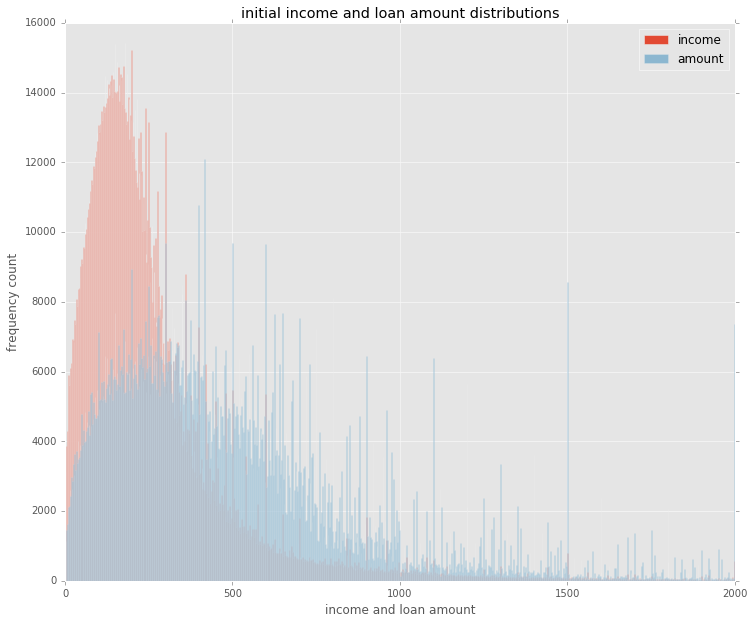

In [29]:
#calculate descriptive stats
print(bank_df.amount.std(), 'std') 
print(bank_df.amount.mean(), 'mean') 
print(bank_df.amount.median(), 'median')
print(bank_df.mult.max(), 'max mult')
print(bank_df.mult.min(), 'min mult')
print(bank_df.amount.quantile(q=.98), '98%')
print(bank_df.amount.quantile(q=.75), 'q3')
print(bank_df.amount.quantile(q=.25), 'q1')
print(bank_df.amount.quantile(q=.02), '02%')
q1 = bank_df.amount.quantile(q=.25)
q3 = bank_df.amount.quantile(q=.75)
q98 = bank_df.amount.quantile(q=.98) #potential upper bound for quality
q2 = bank_df.amount.quantile(q=.02) #potential lower bound for quality
iqr =(q3 - q1)
print(iqr, 'iqr')
min_q = q1 - 1.5 * iqr #potential lower bound for quality
max_q = q3 + 1.5 * iqr #potential upper bound for quality
print(min_q, 'min_q', max_q, 'max_q')


amt = bank_df.amount #get data as series for graphing
inc = bank_df.income #get data as series for graphing
bins = np.linspace(0,2000, 1000) #set ranges and number of bins
bank_viz = plt.figure(figsize=(12,10)) #set plot size
plt.hist(inc, bins, label='income', alpha=1) #plot histogram of income
plt.hist(amt, bins, label='amount', alpha=.5) #plot histogram of loan amount
plt.legend(loc='upper right') #turn on legend and set location
plt.title('initial income and loan amount distributions')
plt.xlabel('income and loan amount')
plt.ylabel('frequency count')
plt.show()
#FIXME add 2 box plot viz



iteration 1
name 0 to 20
std 97.3993246928
mean 139.090430981
median 121.0
max_mult 432.0
med_mult 11.428571428571429
min_mult 0.0526315789474
q98 387.0
q02 7.0
q75 195.0
q25 62.0
iqr 133.0
min_q -137.5
max_q 394.5
count of loans 46101
pct of total loans 1.99879987895


iteration 2
name 0 to 20
std 91.3856404639
mean 134.406831867
median 119.0
max_mult 392.0
med_mult 11.210526315789474
min_mult 0.0526315789474
q98 355.42
q02 7.0
q75 190.0
q25 61.0
iqr 129.0
min_q -132.5
max_q 383.5
count of loans 46101
pct of total loans 1.99879987895


iteration 3
name 0 to 20
std 89.9456704595
mean 133.234865758
median 118.0
max_mult 383.0
med_mult 11.142857142857142
min_mult 0.0526315789474
q98 350.0
q02 7.0
q75 189.0
q25 61.0
iqr 128.0
min_q -131.0
max_q 381.0
count of loans 46101
pct of total loans 1.99879987895


iteration 4
name 0 to 20
std 89.6868142332
mean 133.020328327
median 118.0
max_mult 380.0
med_mult 11.133333333333333
min_mult 0.0526315789474
q98 349.0
q02 7.0
q75 189.0
q25 61.0
iqr 

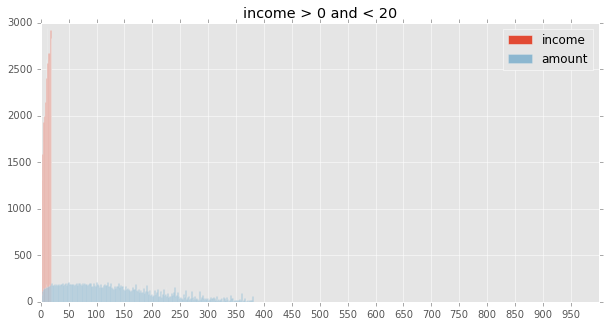



iteration 1
name 20 to 50
std 118.654740377
mean 184.072831876
median 172.0
max_mult 27.35
med_mult 4.977777777777778
min_mult 0.0204081632653
q98 463.0
q02 8.0
q75 264.0
q25 87.0
iqr 177.0
min_q -178.5
max_q 529.5
count of loans 115479
pct of total loans 5.00682005208


iteration 2
name 20 to 50
std 117.260697031
mean 183.031413846
median 171.0
max_mult 26.25
med_mult 4.966666666666667
min_mult 0.0204081632653
q98 452.0
q02 8.0
q75 263.0
q25 87.0
iqr 176.0
min_q -177.0
max_q 527.0
count of loans 115479
pct of total loans 5.00682005208


iteration 3
name 20 to 50
std 117.07207099
mean 182.886569565
median 171.0
max_mult 26.25
med_mult 4.964285714285714
min_mult 0.0204081632653
q98 450.82
q02 8.0
q75 263.0
q25 87.0
iqr 176.0
min_q -177.0
max_q 527.0
count of loans 115479
pct of total loans 5.00682005208


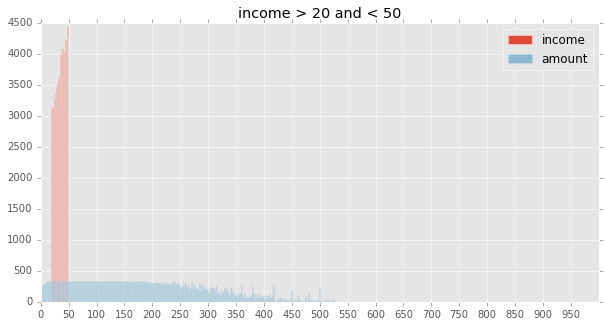



iteration 1
name 50 to 80
std 148.714818455
mean 244.098320775
median 236.0
max_mult 14.06
med_mult 3.6527777777777777
min_mult 0.0126582278481
q98 575.0
q02 14.0
q75 352.0
q25 120.0
iqr 232.0
min_q -228.0
max_q 700.0
count of loans 154011
pct of total loans 6.67745099144


iteration 2
name 50 to 80
std 148.056118522
mean 243.620252081
median 235.0
max_mult 13.96
med_mult 3.6481481481481484
min_mult 0.0126582278481
q98 570.0
q02 14.0
q75 351.0
q25 120.0
iqr 231.0
min_q -226.5
max_q 697.5
count of loans 154011
pct of total loans 6.67745099144


iteration 3
name 50 to 80
std 147.965680872
mean 243.554402849
median 235.0
max_mult 13.92
med_mult 3.647887323943662
min_mult 0.0126582278481
q98 570.0
q02 14.0
q75 351.0
q25 120.0
iqr 231.0
min_q -226.5
max_q 697.5
count of loans 154011
pct of total loans 6.67745099144


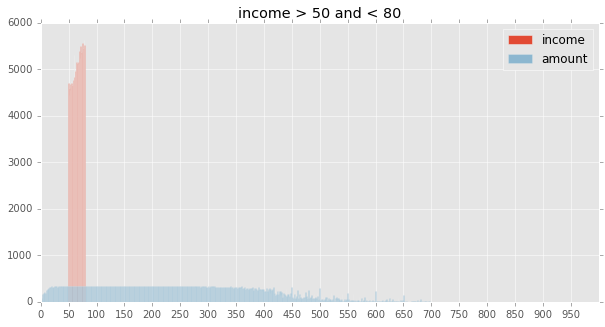



iteration 1
name 80 to 110
std 176.276878467
mean 302.54054127
median 295.0
max_mult 10.625
med_mult 3.1192660550458715
min_mult 0.00917431192661
q98 663.0
q02 24.0
q75 436.0
q25 154.0
iqr 282.0
min_q -269.0
max_q 859.0
count of loans 186685
pct of total loans 8.0940967745


iteration 2
name 80 to 110
std 176.082254051
mean 302.404577351
median 295.0
max_mult 10.625
med_mult 3.118811881188119
min_mult 0.00917431192661
q98 662.0
q02 24.0
q75 436.0
q25 154.0
iqr 282.0
min_q -269.0
max_q 859.0
count of loans 186685
pct of total loans 8.0940967745


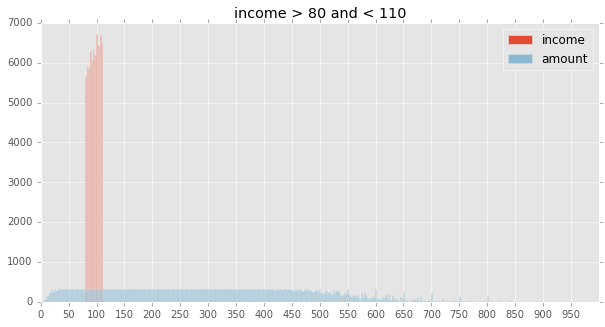



iteration 1
name 110 to 140
std 198.720890806
mean 352.615827692
median 343.0
max_mult 8.94545454545
med_mult 2.7560975609756095
min_mult 0.00719424460432
q98 754.0
q02 35.0
q75 504.0
q25 186.0
iqr 318.0
min_q -291.0
max_q 981.0
count of loans 208324
pct of total loans 9.03229834454


iteration 2
name 110 to 140
std 198.651179996
mean 352.567087715
median 343.0
max_mult 8.90909090909
med_mult 2.7560975609756095
min_mult 0.00719424460432
q98 753.0
q02 35.0
q75 504.0
q25 186.0
iqr 318.0
min_q -291.0
max_q 981.0
count of loans 208324
pct of total loans 9.03229834454


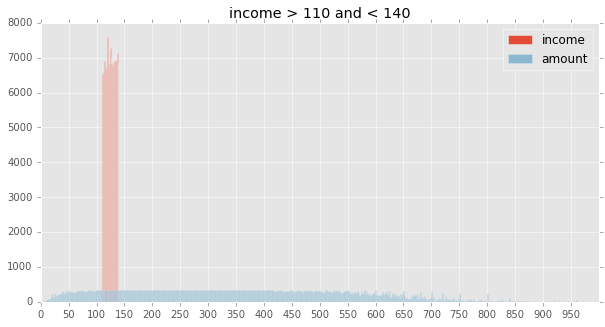



iteration 1
name 140 to 170
std 216.280434874
mean 394.423041311
median 379.0
max_mult 7.6
med_mult 2.45578231292517
min_mult 0.00591715976331
q98 862.0
q02 50.0
q75 554.0
q25 216.0
iqr 338.0
min_q -291.0
max_q 1061.0
count of loans 215154
pct of total loans 9.32842648001


iteration 2
name 140 to 170
std 216.206710602
mean 394.369839822
median 379.0
max_mult 7.51773049645
med_mult 2.45578231292517
min_mult 0.00591715976331
q98 860.0
q02 50.0
q75 554.0
q25 216.0
iqr 338.0
min_q -291.0
max_q 1061.0
count of loans 215154
pct of total loans 9.32842648001


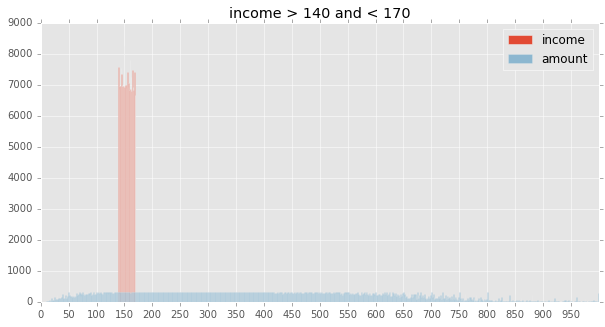



iteration 1
name 170 to 200
std 230.952073638
mean 431.937473762
median 409.0
max_mult 6.65294117647
med_mult 2.2267441860465116
min_mult 0.00502512562814
q98 950.0
q02 63.0
q75 596.0
q25 246.0
iqr 350.0
min_q -279.0
max_q 1121.0
count of loans 206571
pct of total loans 8.95629356834


iteration 2
name 170 to 200
std 230.494503438
mean 431.595320307
median 409.0
max_mult 6.58823529412
med_mult 2.225806451612903
min_mult 0.00502512562814
q98 948.0
q02 63.0
q75 596.0
q25 246.0
iqr 350.0
min_q -279.0
max_q 1121.0
count of loans 206571
pct of total loans 8.95629356834


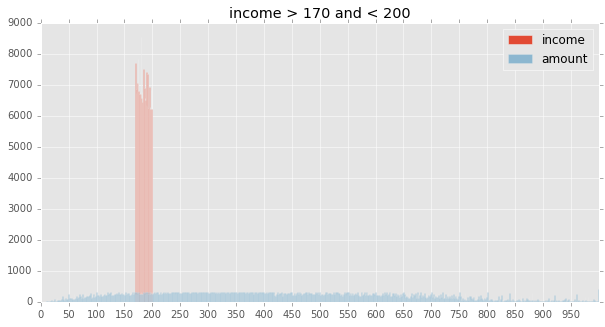



iteration 1
name 200 to 230
std 247.791386046
mean 470.837471366
median 446.0
max_mult 6.025
med_mult 2.0844444444444443
min_mult 0.00442477876106
q98 1020.0
q02 75.0
q75 640.0
q25 274.0
iqr 366.0
min_q -275.0
max_q 1189.0
count of loans 185926
pct of total loans 8.0611888309


iteration 2
name 200 to 230
std 245.902600014
mean 469.390217972
median 446.0
max_mult 5.94
med_mult 2.080568720379147
min_mult 0.00442477876106
q98 1000.0
q02 75.0
q75 640.0
q25 274.0
iqr 366.0
min_q -275.0
max_q 1189.0
count of loans 185926
pct of total loans 8.0611888309


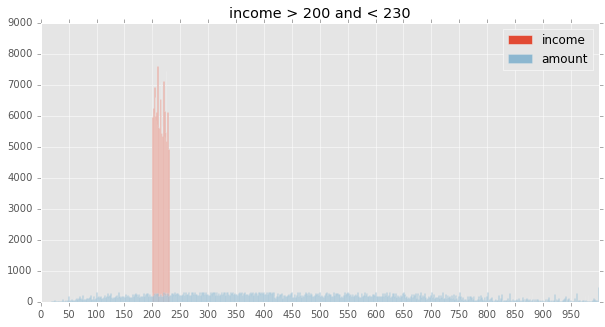



iteration 1
name 230 to 260
std 266.786819179
mean 508.925562232
median 486.0
max_mult 5.63043478261
med_mult 1.9916666666666667
min_mult 0.00395256916996
q98 1121.0
q02 85.0
q75 688.0
q25 298.0
iqr 390.0
min_q -287.0
max_q 1273.0
count of loans 154381
pct of total loans 6.69349307199


iteration 2
name 230 to 260
std 264.405364769
mean 507.076621123
median 485.0
max_mult 5.53043478261
med_mult 1.9873949579831933
min_mult 0.00395256916996
q98 1108.0
q02 84.0
q75 687.0
q25 298.0
iqr 389.0
min_q -285.5
max_q 1270.5
count of loans 154381
pct of total loans 6.69349307199


iteration 3
name 230 to 260
std 264.264106809
mean 506.965662631
median 485.0
max_mult 5.51304347826
med_mult 1.9872881355932204
min_mult 0.00395256916996
q98 1108.0
q02 84.0
q75 686.0
q25 297.0
iqr 389.0
min_q -286.5
max_q 1269.5
count of loans 154381
pct of total loans 6.69349307199


iteration 4
name 230 to 260
std 264.161715368
mean 506.885098885
median 485.0
max_mult 5.51304347826
med_mult 1.9872340425531916
min_m

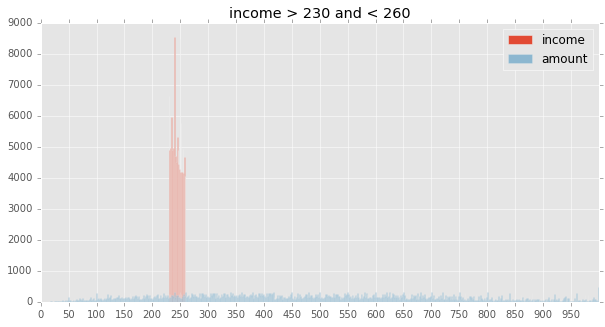



iteration 1
name 260 to 290
std 286.875250353
mean 545.728631484
median 520.0
max_mult 5.28846153846
med_mult 1.9
min_mult 0.00353356890459
q98 1220.0
q02 94.0
q75 730.0
q25 320.0
iqr 410.0
min_q -295.0
max_q 1345.0
count of loans 124780
pct of total loans 5.41008327141


iteration 2
name 260 to 290
std 283.290068093
mean 542.862771761
median 519.0
max_mult 5.16923076923
med_mult 1.8943661971830985
min_mult 0.00353356890459
q98 1200.0
q02 94.0
q75 728.0
q25 319.0
iqr 409.0
min_q -294.5
max_q 1341.5
count of loans 124780
pct of total loans 5.41008327141


iteration 3
name 260 to 290
std 283.127716514
mean 542.731545054
median 519.0
max_mult 5.15384615385
med_mult 1.8940767584018983
min_mult 0.00353356890459
q98 1200.0
q02 94.0
q75 728.0
q25 319.0
iqr 409.0
min_q -294.5
max_q 1341.5
count of loans 124780
pct of total loans 5.41008327141


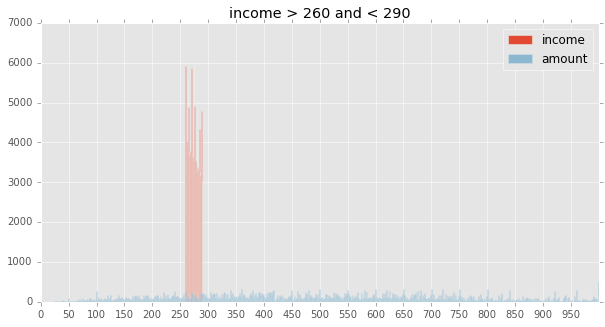



iteration 1
name 290 to 320
std 320.868277153
mean 592.313445724
median 560.0
max_mult 5.1724137931
med_mult 1.8424657534246576
min_mult 0.00324675324675
q98 1350.0
q02 97.0
q75 795.0
q25 339.0
iqr 456.0
min_q -345.0
max_q 1479.0
count of loans 101125
pct of total loans 4.38447404088


iteration 2
name 290 to 320
std 315.564760616
mean 588.05900571
median 557.0
max_mult 5.08275862069
med_mult 1.8360655737704918
min_mult 0.00324675324675
q98 1325.0
q02 97.0
q75 790.0
q25 338.0
iqr 452.0
min_q -340.0
max_q 1468.0
count of loans 101125
pct of total loans 4.38447404088


iteration 3
name 290 to 320
std 314.471169493
mean 587.166532022
median 556.5
max_mult 5.04482758621
med_mult 1.8344263352541499
min_mult 0.00324675324675
q98 1320.0
q02 97.0
q75 789.0
q25 337.0
iqr 452.0
min_q -341.0
max_q 1467.0
count of loans 101125
pct of total loans 4.38447404088


iteration 4
name 290 to 320
std 314.427797051
mean 587.130991093
median 556.0
max_mult 5.04482758621
med_mult 1.8344155844155845
min_mul

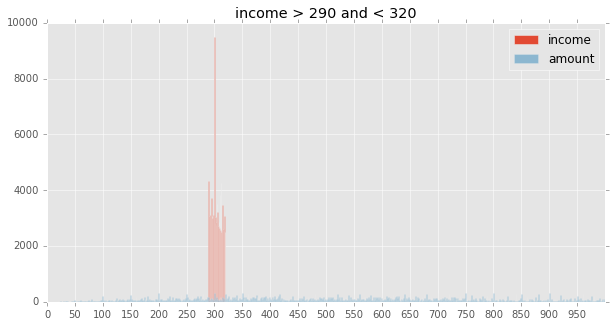



iteration 1
name 320 to 350
std 343.381126865
mean 630.05421982
median 592.0
max_mult 5.084375
med_mult 1.7774480712166172
min_mult 0.00290697674419
q98 1440.0
q02 101.0
q75 850.0
q25 356.0
iqr 494.0
min_q -385.0
max_q 1591.0
count of loans 80861
pct of total loans 3.5058883107


iteration 2
name 320 to 350
std 339.614592853
mean 627.054134466
median 592.0
max_mult 4.96875
med_mult 1.772594752186589
min_mult 0.00290697674419
q98 1425.0
q02 101.0
q75 848.0
q25 356.0
iqr 492.0
min_q -382.0
max_q 1586.0
count of loans 80861
pct of total loans 3.5058883107


iteration 3
name 320 to 350
std 339.343697407
mean 626.835781748
median 592.0
max_mult 4.953125
med_mult 1.7723076923076924
min_mult 0.00290697674419
q98 1425.0
q02 101.0
q75 848.0
q25 356.0
iqr 492.0
min_q -382.0
max_q 1586.0
count of loans 80861
pct of total loans 3.5058883107


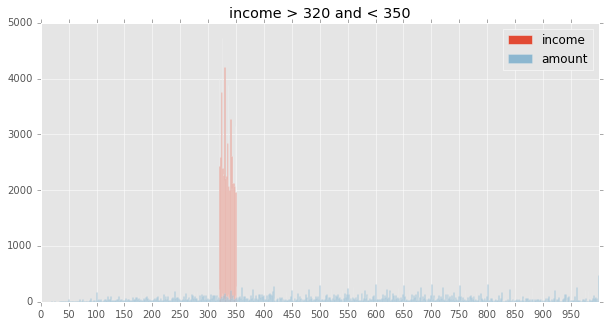



iteration 1
name 350 to 380
std 368.917585419
mean 658.763631842
median 615.0
max_mult 4.98285714286
med_mult 1.6910112359550562
min_mult 0.00268817204301
q98 1500.0
q02 100.0
q75 898.0
q25 363.0
iqr 535.0
min_q -439.5
max_q 1700.5
count of loans 69671
pct of total loans 3.02072376665


iteration 2
name 350 to 380
std 365.768217907
mean 656.29853504
median 614.0
max_mult 4.85714285714
med_mult 1.6888888888888889
min_mult 0.00268817204301
q98 1500.0
q02 100.0
q75 895.0
q25 362.0
iqr 533.0
min_q -437.5
max_q 1694.5
count of loans 69671
pct of total loans 3.02072376665


iteration 3
name 350 to 380
std 364.114739222
mean 654.981338188
median 613.0
max_mult 4.82857142857
med_mult 1.6876712328767123
min_mult 0.00268817204301
q98 1496.0
q02 100.0
q75 893.0
q25 362.0
iqr 531.0
min_q -434.5
max_q 1689.5
count of loans 69671
pct of total loans 3.02072376665


iteration 4
name 350 to 380
std 363.830013773
mean 654.753128121
median 613.0
max_mult 4.82571428571
med_mult 1.6873277400250561
min_mu

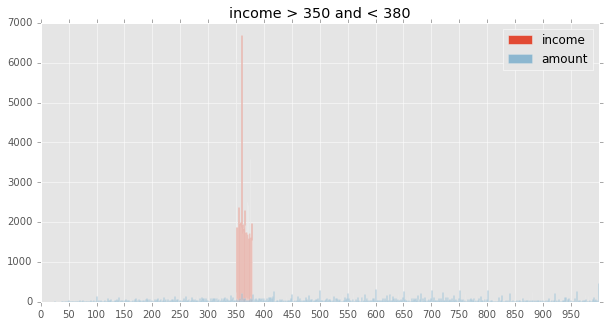



iteration 1
name 380 to 410
std 391.882839015
mean 690.3284982
median 637.5
max_mult 4.7874015748
med_mult 1.613551348900476
min_mult 0.0025
q98 1600.0
q02 102.0
q75 943.0
q25 375.0
iqr 568.0
min_q -477.0
max_q 1795.0
count of loans 56112
pct of total loans 2.43284655013


iteration 2
name 380 to 410
std 387.502981138
mean 686.850299947
median 635.0
max_mult 4.70526315789
med_mult 1.6105263157894736
min_mult 0.0025
q98 1590.16
q02 102.0
q75 940.0
q25 375.0
iqr 565.0
min_q -472.5
max_q 1787.5
count of loans 56112
pct of total loans 2.43284655013


iteration 3
name 380 to 410
std 387.126037841
mean 686.548478879
median 635.0
max_mult 4.69736842105
med_mult 1.6103896103896105
min_mult 0.0025
q98 1585.46
q02 102.0
q75 939.25
q25 375.0
iqr 564.25
min_q -471.375
max_q 1785.625
count of loans 56112
pct of total loans 2.43284655013


iteration 4
name 380 to 410
std 387.101038908
mean 686.528407536
median 635.0
max_mult 4.69736842105
med_mult 1.6103896103896105
min_mult 0.0025
q98 1585.0
q02 

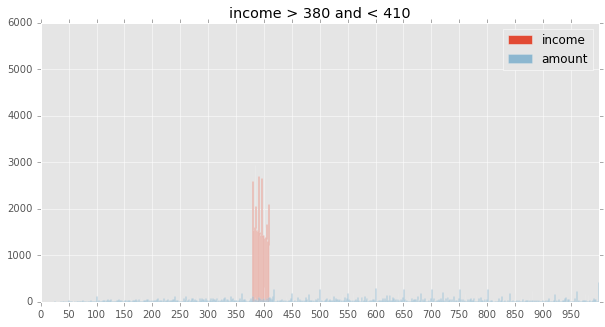



iteration 1
name 410 to 440
std 421.513700375
mean 732.633754896
median 675.0
max_mult 4.69512195122
med_mult 1.591647331786543
min_mult 0.00231481481481
q98 1725.0
q02 102.0
q75 996.0
q25 394.0
iqr 602.0
min_q -509.0
max_q 1899.0
count of loans 45579
pct of total loans 1.97616753829


iteration 2
name 410 to 440
std 416.76116548
mean 728.785807321
median 673.0
max_mult 4.62682926829
med_mult 1.5857142857142856
min_mult 0.00231481481481
q98 1700.0
q02 102.0
q75 994.0
q25 393.0
iqr 601.0
min_q -508.5
max_q 1895.5
count of loans 45579
pct of total loans 1.97616753829


iteration 3
name 410 to 440
std 416.6328885
mean 728.680905538
median 673.0
max_mult 4.61463414634
med_mult 1.5857142857142856
min_mult 0.00231481481481
q98 1700.0
q02 102.0
q75 994.0
q25 393.0
iqr 601.0
min_q -508.5
max_q 1895.5
count of loans 45579
pct of total loans 1.97616753829


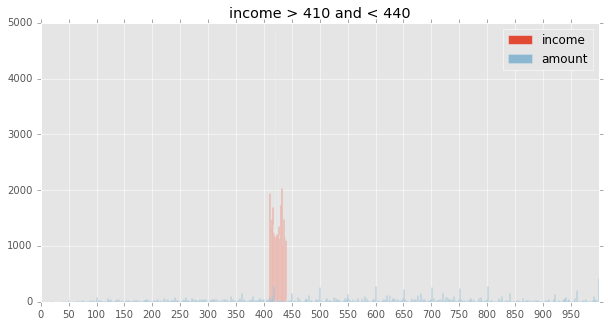



iteration 1
name 440 to 470
std 451.740609298
mean 763.269958738
median 697.0
max_mult 4.67800453515
med_mult 1.5317286652078774
min_mult 0.00226757369615
q98 1855.0
q02 102.0
q75 1040.0
q25 400.0
iqr 640.0
min_q -560.0
max_q 2000.0
count of loans 38168
pct of total loans 1.65484900067


iteration 2
name 440 to 470
std 440.52088171
mean 754.089353714
median 692.0
max_mult 4.52607709751
med_mult 1.5217391304347827
min_mult 0.00226757369615
q98 1792.0
q02 102.0
q75 1020.0
q25 400.0
iqr 620.0
min_q -530.0
max_q 1950.0
count of loans 38168
pct of total loans 1.65484900067


iteration 3
name 440 to 470
std 433.351469215
mean 748.19205066
median 689.0
max_mult 4.41590909091
med_mult 1.5159502810622212
min_mult 0.00226757369615
q98 1752.0
q02 101.18
q75 1010.0
q25 398.0
iqr 612.0
min_q -520.0
max_q 1928.0
count of loans 38168
pct of total loans 1.65484900067


iteration 4
name 440 to 470
std 431.507389037
mean 746.650180778
median 688.0
max_mult 4.37045454545
med_mult 1.5138680733583119
min

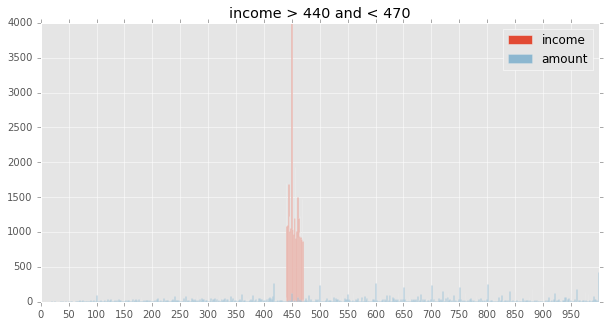



iteration 1
name 470 to 500
std 474.60476782
mean 789.391856227
median 711.0
max_mult 4.6186440678
med_mult 1.4698187912942091
min_mult 0.0020325203252
q98 1932.92
q02 100.0
q75 1098.0
q25 405.0
iqr 693.0
min_q -634.5
max_q 2137.5
count of loans 32368
pct of total loans 1.40337854888


iteration 2
name 470 to 500
std 470.611170653
mean 786.278435571
median 710.0
max_mult 4.49576271186
med_mult 1.4675052410901468
min_mult 0.0020325203252
q98 1914.9
q02 100.0
q75 1090.0
q25 404.0
iqr 686.0
min_q -625.0
max_q 2119.0
count of loans 32368
pct of total loans 1.40337854888


iteration 3
name 470 to 500
std 469.873441505
mean 785.687732342
median 709.0
max_mult 4.46808510638
med_mult 1.46723044397463
min_mult 0.0020325203252
q98 1910.0
q02 100.0
q75 1088.0
q25 404.0
iqr 684.0
min_q -622.0
max_q 2114.0
count of loans 32368
pct of total loans 1.40337854888


iteration 4
name 470 to 500
std 469.873441505
mean 785.687732342
median 709.0
max_mult 4.46808510638
med_mult 1.46723044397463
min_mult 0

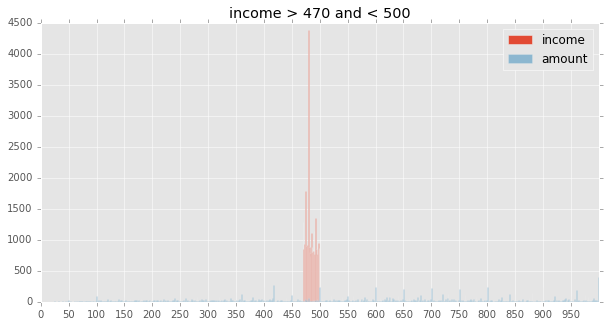



iteration 1
name 500 to 530
std 500.785129566
mean 823.394193015
median 732.0
max_mult 4.66
med_mult 1.4326649394249014
min_mult 0.00196078431373
q98 2000.0
q02 107.66
q75 1145.0
q25 416.0
iqr 729.0
min_q -677.5
max_q 2238.5
count of loans 29552
pct of total loans 1.28128530884


iteration 2
name 500 to 530
std 491.759315141
mean 816.475931758
median 730.0
max_mult 4.452
med_mult 1.4285714285714286
min_mult 0.00196078431373
q98 1990.08
q02 107.0
q75 1133.0
q25 415.0
iqr 718.0
min_q -662.0
max_q 2210.0
count of loans 29552
pct of total loans 1.28128530884


iteration 3
name 500 to 530
std 490.418435162
mean 815.406891775
median 730.0
max_mult 4.4
med_mult 1.4274661508704063
min_mult 0.00196078431373
q98 1980.0
q02 107.0
q75 1130.0
q25 415.0
iqr 715.0
min_q -657.5
max_q 2202.5
count of loans 29552
pct of total loans 1.28128530884


iteration 4
name 500 to 530
std 490.119587181
mean 815.166158642
median 730.0
max_mult 4.4
med_mult 1.4272030651340997
min_mult 0.00196078431373
q98 1980.0


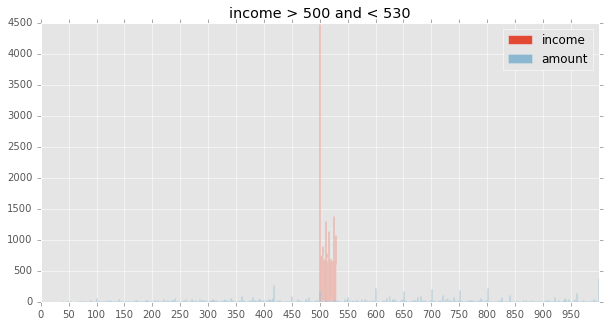



iteration 1
name 530 to 560
std 526.803567138
mean 849.764463872
median 750.0
max_mult 4.59510357815
med_mult 1.3761467889908257
min_mult 0.0179211469534
q98 2100.0
q02 104.0
q75 1200.0
q25 417.0
iqr 783.0
min_q -757.5
max_q 2374.5
count of loans 23776
pct of total loans 1.03085542443


iteration 2
name 530 to 560
std 519.818282022
mean 844.478735756
median 750.0
max_mult 4.45009416196
med_mult 1.3736263736263736
min_mult 0.0179211469534
q98 2031.0
q02 104.0
q75 1196.0
q25 417.0
iqr 779.0
min_q -751.5
max_q 2364.5
count of loans 23776
pct of total loans 1.03085542443


iteration 3
name 530 to 560
std 519.733181682
mean 844.413133224
median 750.0
max_mult 4.45009416196
med_mult 1.3734073897117376
min_mult 0.0179211469534
q98 2030.94
q02 104.0
q75 1196.0
q25 417.0
iqr 779.0
min_q -751.5
max_q 2364.5
count of loans 23776
pct of total loans 1.03085542443


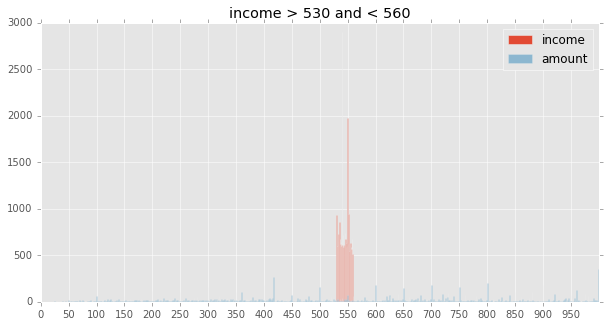

bin stop **************************************************


iteration 1
name 561 and up
std 1136.06653357
mean 1199.80001294
median 960.0
max_mult 128.533419023
med_mult 1.0252008799138492
min_mult 0.000357142857143
q98 4000.0
q02 105.0
q75 1575.0
q25 485.0
iqr 1090.0
min_q -1150.0
max_q 3210.0
count of loans 231810
pct of total loans 10.0505802464


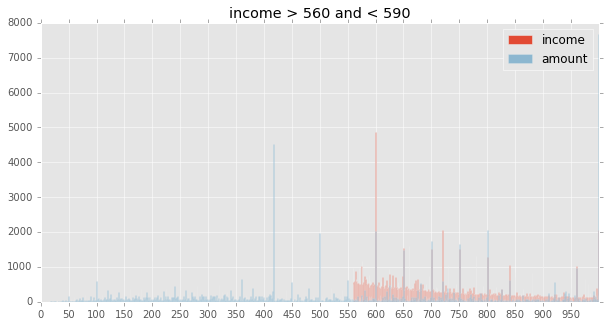

In [30]:
#Cycle over different income bins and plot loan amount distribution for each
#focus on finding the best bins
#repeat for different SQL selection filters (junior liens, non-owner-occupied, VA/FHA/RHS loans, manufactured housing)
bin_min = 0
bin_max = 20
bin_step = 30
bin_stop = 561
pct_of_loans = OrderedDict({})
end_flag = False
first = True
while bin_max < bank_df.income.max():
    bin_stats = OrderedDict({})
    if end_flag == True:
        break
    if bin_max >= bin_stop:
        end_flag = True
        graph_bin = bank_df[(bank_df.income >= bin_min)] #create tail bin for income over bin_stop
        print("bin stop", "*"*50)
        bin_stats['name'] = str(bin_stop) + ' and up' #set name for tail bin
    else:
        graph_bin = bank_df[(bank_df.income >=bin_min) & (bank_df.income < bin_max)] #create bin of of amount for selected income
        bin_stats['name'] = str(bin_min) + ' to ' + str(bin_max)
    #set descriptive stats

    bin_stats['std']= graph_bin.amount.std()
    bin_stats['mean'] = graph_bin.amount.mean()
    bin_stats['median'] = graph_bin.amount.median()
    bin_stats['max_mult'] = graph_bin.mult.max()
    bin_stats['med_mult'] = graph_bin.mult.median()
    bin_stats['min_mult'] = graph_bin.mult.min()
    bin_stats['q98'] = graph_bin.amount.quantile(q=.98)
    bin_stats['q02'] = graph_bin.amount.quantile(q=.02)
    bin_stats['q75'] = graph_bin.amount.quantile(q=.75)
    bin_stats['q25'] = graph_bin.amount.quantile(q=.25)
    bin_stats['iqr'] = bin_stats['q75'] - bin_stats['q25']
    bin_stats['min_q'] = bin_stats['q25'] - 1.5 * bin_stats['iqr']
    bin_stats['max_q'] = bin_stats['q75'] + 1.5 * bin_stats['iqr']
    bin_stats['count of loans'] = graph_bin.amount.count()
    bin_stats['pct of total loans'] = (graph_bin.amount.count() / bank_df.income.count()) * 100

    #iterate over dataframe bin to remove outliers using IQR * 1.5
    count=1
    while True:
        #remove outliers
        start_max_q = bin_stats['max_q']
        if bin_max >= bin_stop and count == 1:
            graph_bin = bank_df[(bank_df.income >= bin_min)] #create tail bin for income over bin_stop
        else:
            graph_bin = graph_bin[(graph_bin.amount > bin_stats['min_q']) & (graph_bin.amount < bin_stats['max_q'])]
        print('\n\niteration {num}'.format(num=count))
        #reset bin stats to reflect IQR cutoffs
        bin_stats['std']= graph_bin.amount.std()
        bin_stats['mean'] = graph_bin.amount.mean()
        bin_stats['median'] = graph_bin.amount.median()
        bin_stats['max_mult'] = graph_bin.mult.max()
        bin_stats['med_mult'] = graph_bin.mult.median()
        bin_stats['min_mult'] = graph_bin.mult.min()
        bin_stats['q98'] = graph_bin.amount.quantile(q=.98)
        bin_stats['q02'] = graph_bin.amount.quantile(q=.02)
        bin_stats['q75'] = graph_bin.amount.quantile(q=.75)
        bin_stats['q25'] = graph_bin.amount.quantile(q=.25)
        bin_stats['iqr'] = bin_stats['q75'] - bin_stats['q25']
        bin_stats['min_q'] = bin_stats['q25'] - 1.5 * bin_stats['iqr']
        bin_stats['max_q'] = bin_stats['q75'] + 1.5 * bin_stats['iqr']

        count+=1
        for key, value in bin_stats.items(): #print descriptive stats
            print(key,value)
        
        if start_max_q == bin_stats['max_q'] or count > 10:
            break
            
    if first: 
        first = False
        bin_df = pd.DataFrame(bin_stats, index=range(1)) #instantiate initial dataframe
    else:
        concat_df = pd.DataFrame(bin_stats, index=range(1)) #instantiate subsequent dataframe 
        bin_df = pd.concat([bin_df, concat_df], axis=0) #concatenate dataframes each cycle
    
    amt = graph_bin.amount#.apply(sqrt)
    inc = graph_bin.income#.apply(sqrt) #square roots show much nicer distributions of amount to income
    xmin = 0 #set minimum x axis value
    xmax = 1000 #set maximum x axis value
    xsteps= 1000 #set steps on x axis (bins)
    bins = np.linspace(xmin,xmax, xsteps)
    #print(bins)
    bin_viz = plt.figure(figsize=(10,5))
    plt.hist(inc, bins, label='income', alpha=1)
    plt.hist(amt, bins, label='amount', alpha=.5)
    plt.title('income > '+str(bin_min)+' and < '+str(bin_max))
    plt.legend(loc='upper right')
    plt.xticks(np.arange(xmin,xmax, 50))
    ax = plt.subplot()
    #ax.set_ylim(0, 2000)
    plt.show(bin_viz)
    bin_min=bin_max
    bin_max += bin_step
    pct_of_loans[bin_max] = bin_stats['pct of total loans']
    
path = '../linked_dist_stats/'
if not os.path.exists(path):
    os.makedirs(path)
bin_df.to_csv(path+'IQR_{loanType}.csv'.format(loanType=loanType))

In [31]:

bin_df.reset_index(inplace=True, drop=True) #set an integer index instead of index passed at creation
bin_df.head(20)

,name,std,mean,median,max_mult,med_mult,min_mult,q98,q02,q75,q25,iqr,min_q,max_q,count of loans,pct of total loans
0,0 to 20,89.686814,133.020328,118.0,380.000000,11.133333,0.052632,349.00,7.0,189.0,61.0,128.0,-131.0,381.0,46101,1.998800
1,20 to 50,117.072071,182.886570,171.0,26.250000,4.964286,0.020408,450.82,8.0,263.0,87.0,176.0,-177.0,527.0,115479,5.006820
2,50 to 80,147.965681,243.554403,235.0,13.920000,3.647887,0.012658,570.00,14.0,351.0,120.0,231.0,-226.5,697.5,154011,6.677451
3,80 to 110,176.082254,302.404577,295.0,10.625000,3.118812,0.009174,662.00,24.0,436.0,154.0,282.0,-269.0,859.0,186685,8.094097
4,110 to 140,198.651180,352.567088,343.0,8.909091,2.756098,0.007194,753.00,35.0,504.0,186.0,318.0,-291.0,981.0,208324,9.032298
5,140 to 170,216.206711,394.369840,379.0,7.517730,2.455782,0.005917,860.00,50.0,554.0,216.0,338.0,-291.0,1061.0,215154,9.328426
6,170 to 200,230.494503,431.595320,409.0,6.588235,2.225806,0.005025,948.00,63.0,596.0,246.0,350.0,-279.0,1121.0,206571,8.956294
7,200 to 230,245.902600,469.390218,446.0,5.940000,2.080569,0.004425,1000.00,75.0,640.0,274.0,366.0,-275.0,1189.0,185926,8.061189
8,230 to 260,264.161715,506.885099,485.0,5.513043,1.987234,0.003953,1106.24,84.0,686.0,297.0,389.0,-286.5,1269.5,154381,6.693493
9,260 to 290,283.127717,542.731545,519.0,5.153846,1.894077,0.003534,1200.00,94.0,728.0,319.0,409.0,-294.5,1341.5,124780,5.410083


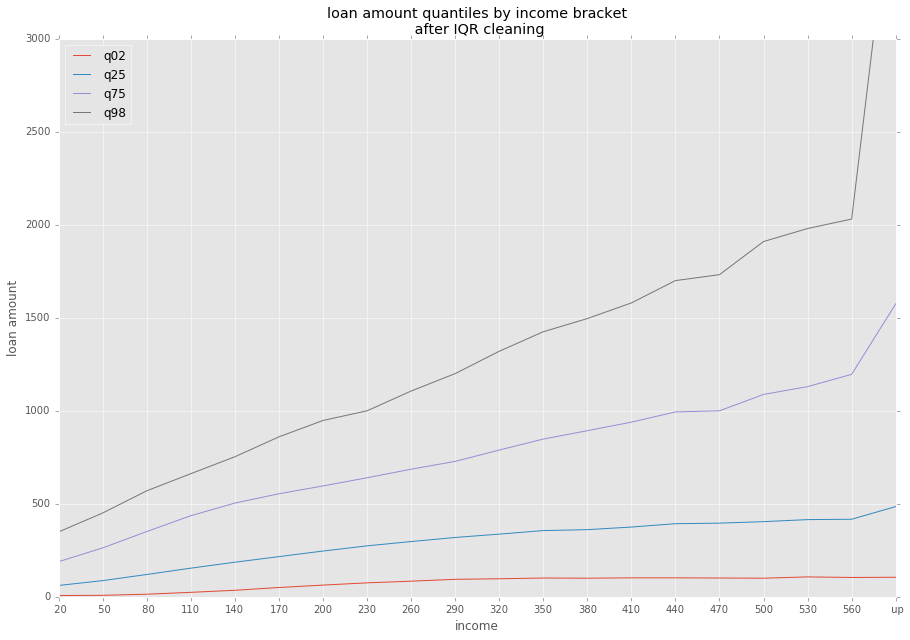

In [32]:
fig = plt.figure(figsize=(15,10))
xticks=[x[-3:] for x in bin_df.name] #get xtick names as list
ax = plt.subplot()
x = range(len(bin_df.name))
plt.xticks(x,xticks) #set xtick names


y = bin_df.q02
y1 = bin_df.q25
y2 = bin_df.q75
y3 = bin_df.q98
plt.plot(x,y, label='q02')
plt.plot(x,y1, label='q25')
plt.plot(x,y2, label='q75')
plt.plot(x,y3, label='q98')
ax=plt.subplot()
ax.set_ylim(0,3000)
plt.ylabel('loan amount')
plt.xlabel('income')
plt.legend(loc='upper left') #turn on legend and set location
plt.title('loan amount quantiles by income bracket\n after IQR cleaning')
plt.show(fig)